<a href="https://colab.research.google.com/github/Carine-Ashimwe/Summative-Assignment-SAHeart-Project/blob/main/Summative_Assignment_Model_Training_and_Evaluation_Carine_Ashimwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summative Assignment - Model Training and Evaluation

A reproducible pipeline comparing classical ML (scikit-learn) and Deep Learning (TensorFlow) to predict coronary heart disease (binary). This notebook is structured to meet the assignment rubric (data, preprocessing, experiments, evaluation, discussion, reproducibility).

In [59]:
#Environment & reproducibility
RANDOM_SEED = 42

# !pip install --quiet scikit-learn==1.3.2 tensorflow==2.13.0 xgboost optuna

import os, random, math, sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Python:", sys.version.splitlines()[0])
import sklearn
print("scikit-learn:", sklearn.__version__)
import tensorflow as tf
print("tensorflow:", tf.__version__)


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
scikit-learn: 1.6.1
tensorflow: 2.19.0


## Load dataset

This notebook uses the **South African Heart Disease (SAHeart)** dataset (commonly called `SAheart`), a retrospective dataset collected in the Western Cape, South Africa.

In [60]:
# Load dataset
LOCAL_CSV_PATH = None

example_raw = "https://raw.githubusercontent.com/itsliterallymonique/Two-Class-Classification-on-South-African-Heart-Disease-dataset/main/saheart.csv"

def load_csv(local_path=None, url=example_raw):
    if local_path:
        print("Loading from local path:", local_path)
        return pd.read_csv(local_path)
    else:
        try:
            print("Trying to load from example raw URL:", url)
            return pd.read_csv(url)
        except Exception as e:
            raise RuntimeError("Could not download CSV automatically. Upload your CSV and set LOCAL_CSV_PATH. Error: " + str(e))

df = load_csv(LOCAL_CSV_PATH)
print("Loaded dataset shape:", df.shape)
df.head()


Trying to load from example raw URL: https://raw.githubusercontent.com/itsliterallymonique/Two-Class-Classification-on-South-African-Heart-Disease-dataset/main/saheart.csv
Loaded dataset shape: (462, 11)


,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


## Quick EDA

- Inspect columns, data types, missing values, distributions and correlations.
- Visualize class balance and key features.


In [61]:
# Quick EDA - overview, dtypes, missing values, target balance
display(df.info())
display(df.describe(include='all').T)

print("\nMissing values per column:")
print(df.isna().sum())

# Try to detect a plausible binary target
possible_targets = [c for c in df.columns if c.lower() in ('chd','target','cardio','has_disease','cardiovascular')]
print("\nCandidate target columns:", possible_targets)

# If 'chd' exists show its distribution
if 'chd' in df.columns:
    print("\nValue counts for 'chd':")
    print(df['chd'].value_counts())
else:
    print("\nNo 'chd' column found. You should set TARGET variable later.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row.names  462 non-null    int64  
 1   sbp        462 non-null    int64  
 2   tobacco    462 non-null    float64
 3   ldl        462 non-null    float64
 4   adiposity  462 non-null    float64
 5   famhist    462 non-null    object 
 6   typea      462 non-null    int64  
 7   obesity    462 non-null    float64
 8   alcohol    462 non-null    float64
 9   age        462 non-null    int64  
 10  chd        462 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
row.names,462.0,NaN,NaN,NaN,231.935065,133.938585,1.0,116.25,231.5,347.75,463.0
sbp,462.0,NaN,NaN,NaN,138.32684,20.496317,101.0,124.0,134.0,148.0,218.0
tobacco,462.0,NaN,NaN,NaN,3.635649,4.593024,0.0,0.0525,2.0,5.5,31.2
ldl,462.0,NaN,NaN,NaN,4.740325,2.070909,0.98,3.2825,4.34,5.79,15.33
adiposity,462.0,NaN,NaN,NaN,25.406732,7.780699,6.74,19.775,26.115,31.2275,42.49
famhist,462,2,Absent,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
typea,462.0,NaN,NaN,NaN,53.103896,9.817534,13.0,47.0,53.0,60.0,78.0
obesity,462.0,NaN,NaN,NaN,26.044113,4.21368,14.7,22.985,25.805,28.4975,46.58
alcohol,462.0,NaN,NaN,NaN,17.044394,24.481059,0.0,0.51,7.51,23.8925,147.19
age,462.0,NaN,NaN,NaN,42.816017,14.608956,15.0,31.0,45.0,55.0,64.0



Missing values per column:
row.names    0
sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

Candidate target columns: ['chd']

Value counts for 'chd':
chd
0    302
1    160
Name: count, dtype: int64


## Data preprocessing & feature engineering

Steps included in this section (all reproducible):
- Handling missing values, outliers, and implausible values
- Encoding categorical variables
- Scaling numeric variables
- Train/validation/test split with stratification
- Save preprocessing pipeline for reproducibility


In [62]:
# Build preprocessing pipeline (handles sklearn version differences)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn

def build_preprocessing_pipeline(df, target_col=None):
    # detect numeric and categorical
    num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

    TARGET = target_col if target_col else ('chd' if 'chd' in df.columns else None)
    if TARGET:
        if TARGET in num_cols: num_cols.remove(TARGET)
        if TARGET in cat_cols: cat_cols.remove(TARGET)

    # numeric
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # categorical: handle sklearn version difference
    if sklearn.__version__ >= '1.4':
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])
    else:
        categorical_transformer = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop')

    return preprocessor, num_cols, cat_cols, TARGET

preprocessor, num_cols, cat_cols, TARGET = build_preprocessing_pipeline(df)
print("Detected numeric cols:", num_cols)
print("Detected categorical cols:", cat_cols)
print("Detected/assumed target:", TARGET)


Detected numeric cols: ['row.names', 'sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
Detected categorical cols: ['famhist']
Detected/assumed target: chd


In [63]:
# Split dataset and apply preprocessing.
from sklearn.model_selection import train_test_split

if TARGET is None:
    raise RuntimeError("TARGET not detected. Either your CSV lacks 'chd' or set target manually in build_preprocessing_pipeline()")

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)  # cast to int if boolean or numeric

# Stratified split: train 70%, val 15%, test 15% (approx)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_SEED)

print("Split sizes:", X_train.shape, X_val.shape, X_test.shape)

# Fit preprocessor on train and transform all sets
preprocessor = preprocessor  # from previous cell
X_train_p = preprocessor.fit_transform(X_train)
X_val_p = preprocessor.transform(X_val)
X_test_p = preprocessor.transform(X_test)

# If onehot produced numpy arrays with object dtype, make float
import numpy as np
X_train_p = np.asarray(X_train_p, dtype=np.float32)
X_val_p = np.asarray(X_val_p, dtype=np.float32)
X_test_p = np.asarray(X_test_p, dtype=np.float32)

print("Preprocessed feature shapes (train/val/test):", X_train_p.shape, X_val_p.shape, X_test_p.shape)


Split sizes: (323, 10) (69, 10) (70, 10)
Preprocessed feature shapes (train/val/test): (323, 11) (69, 11) (70, 11)


In [64]:
# plotting & eval utilities
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay)

def eval_classification(y_true, y_pred, y_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }
    if y_proba is not None:
        try:
            metrics['roc_auc'] = roc_auc_score(y_true, y_proba)
        except Exception:
            metrics['roc_auc'] = None
    else:
        metrics['roc_auc'] = None
    return metrics

def plot_confusion(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='viridis')
    plt.show()

def plot_roc_curve(y_true, y_proba):
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.show()


## Classical ML models (Scikit-learn)

We build and compare: Logistic Regression, Random Forest, SVM, XGBoost. Use stratified train/validation/test splits and cross-validation.

In [65]:
# Classical ML experiments (GridSearch + CV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd, time

models = {
    'LogisticRegression': (LogisticRegression(max_iter=2000, random_state=RANDOM_SEED), {'C':[0.1,1,10]}),
    'RandomForest': (RandomForestClassifier(random_state=RANDOM_SEED), {'n_estimators':[50,100], 'max_depth':[None,5]}),
    'SVC': (SVC(probability=True, random_state=RANDOM_SEED), {'C':[0.1,1], 'kernel':['rbf']})
}
if has_xgb:
    models['XGBoost'] = (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED), {'n_estimators':[50,100], 'learning_rate':[0.01,0.1]})

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_SEED)

results_list = []
for name, (model, grid) in models.items():
    print(f"\nRunning {name} ...")
    gs = GridSearchCV(model, grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0)
    t0 = time.time()
    gs.fit(X_train_p, y_train)
    t1 = time.time()
    best = gs.best_estimator_
    # predictions on test
    y_pred = best.predict(X_test_p)
    try:
        y_proba = best.predict_proba(X_test_p)[:,1]
    except Exception:
        try:
            y_proba = best.decision_function(X_test_p)
        except Exception:
            y_proba = None
    metrics = eval_classification(y_test, y_pred, y_proba)
    metrics.update({
        'model': name,
        'best_params': gs.best_params_,
        'fit_time_sec': round(t1-t0,2)
    })
    results_list.append(metrics)
    print(name, "metrics:", metrics)

results_df = pd.DataFrame(results_list).sort_values('roc_auc', ascending=False)
results_df.reset_index(drop=True, inplace=True)
display(results_df)
# Save results
results_df.to_csv("classical_ml_results.csv", index=False)
print("Saved classical results to classical_ml_results.csv")



Running LogisticRegression ...
LogisticRegression metrics: {'accuracy': 0.7, 'precision': 0.56, 'recall': 0.5833333333333334, 'f1': 0.5714285714285714, 'roc_auc': np.float64(0.7844202898550725), 'model': 'LogisticRegression', 'best_params': {'C': 0.1}, 'fit_time_sec': 5.89}

Running RandomForest ...
RandomForest metrics: {'accuracy': 0.7285714285714285, 'precision': 0.6190476190476191, 'recall': 0.5416666666666666, 'f1': 0.5777777777777777, 'roc_auc': np.float64(0.7690217391304348), 'model': 'RandomForest', 'best_params': {'max_depth': 5, 'n_estimators': 100}, 'fit_time_sec': 5.67}

Running SVC ...
SVC metrics: {'accuracy': 0.6571428571428571, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': np.float64(0.7173913043478262), 'model': 'SVC', 'best_params': {'C': 0.1, 'kernel': 'rbf'}, 'fit_time_sec': 0.41}

Running XGBoost ...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:30:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost metrics: {'accuracy': 0.6142857142857143, 'precision': 0.44, 'recall': 0.4583333333333333, 'f1': 0.4489795918367347, 'roc_auc': np.float64(0.6893115942028986), 'model': 'XGBoost', 'best_params': {'learning_rate': 0.1, 'n_estimators': 50}, 'fit_time_sec': 1.93}


,accuracy,precision,recall,f1,roc_auc,model,best_params,fit_time_sec
0,0.700000,0.560000,0.583333,0.571429,0.784420,LogisticRegression,{'C': 0.1},5.89
1,0.728571,0.619048,0.541667,0.577778,0.769022,RandomForest,"{'max_depth': 5, 'n_estimators': 100}",5.67
2,0.657143,0.000000,0.000000,0.000000,0.717391,SVC,"{'C': 0.1, 'kernel': 'rbf'}",0.41
3,0.614286,0.440000,0.458333,0.448980,0.689312,XGBoost,"{'learning_rate': 0.1, 'n_estimators': 50}",1.93


Saved classical results to classical_ml_results.csv


## 5) Deep Learning (TensorFlow)

We build: a Sequential model and a Functional API model using tf.data for efficient input pipeline. We include callbacks, early stopping, learning rate scheduling, and show learning curves (loss & ROC AUC).

In [66]:
# Prepare tf.data datasets (for DL models)
import tensorflow as tf

BATCH_SIZE = 32

def make_tf_datasets(X_train_np, y_train_np, X_val_np, y_val_np, batch_size=BATCH_SIZE):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np)).shuffle(1024, seed=RANDOM_SEED).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_ds, val_ds

train_ds, val_ds = make_tf_datasets(X_train_p, y_train.values.astype('float32'), X_val_p, y_val.values.astype('float32'))
print(train_ds.element_spec)


(TensorSpec(shape=(None, 11), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [67]:
# Build and train DL models (Sequential + Functional)
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

input_shape = X_train_p.shape[1]
print("Input shape for models:", input_shape)

def make_sequential(input_shape):
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
    return model

def make_functional(input_shape):
    inp = layers.Input(shape=(input_shape,))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='binary_crossentropy', metrics=[keras.metrics.AUC(name='auc')])
    return model

es = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train sequential
seq = make_sequential(input_shape)
history_seq = seq.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[es], verbose=1)

# Evaluate on test set
X_test_tensor = X_test_p.astype('float32')
y_test_tensor = y_test.values.astype('float32')
y_proba_seq = seq.predict(X_test_tensor).ravel()
y_pred_seq = (y_proba_seq >= 0.5).astype(int)
metrics_seq = eval_classification(y_test_tensor, y_pred_seq, y_proba_seq)
metrics_seq['model'] = 'Sequential_DNN'
print("\nSequential model metrics:", metrics_seq)

# Train functional
func = make_functional(input_shape)
history_func = func.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[es], verbose=1)

y_proba_func = func.predict(X_test_tensor).ravel()
y_pred_func = (y_proba_func >= 0.5).astype(int)
metrics_func = eval_classification(y_test_tensor, y_pred_func, y_proba_func)
metrics_func['model'] = 'Functional_DNN'
print("\nFunctional model metrics:", metrics_func)

# Save histories and metrics
import pickle
with open('dl_histories.pkl','wb') as f:
    pickle.dump({'seq': history_seq.history, 'func': history_func.history}, f)
pd.DataFrame([metrics_seq, metrics_func]).to_csv("deep_learning_results.csv", index=False)
print("Saved DL metrics and histories.")


Input shape for models: 11
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - auc: 0.6365 - loss: 0.9142 - val_auc: 0.6755 - val_loss: 0.6743
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - auc: 0.7010 - loss: 0.7458 - val_auc: 0.7245 - val_loss: 0.6380
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - auc: 0.7221 - loss: 0.6373 - val_auc: 0.7417 - val_loss: 0.6132
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - auc: 0.7590 - loss: 0.5932 - val_auc: 0.7537 - val_loss: 0.5942
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7529 - loss: 0.5814 - val_auc: 0.7574 - val_loss: 0.5827
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7733 - loss: 0.5518 - val_auc: 0.7611 - val_loss: 0.5743
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7980 - loss: 0.5194 - val_auc: 0.7620 - val_loss: 0.5686
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - auc: 0.7879 - loss: 0.5279 - val_auc: 0.7662 - val_loss: 0.5641
Epoch 9/100
11/11 ━━━━━━━━━━━

Sequential training curves:


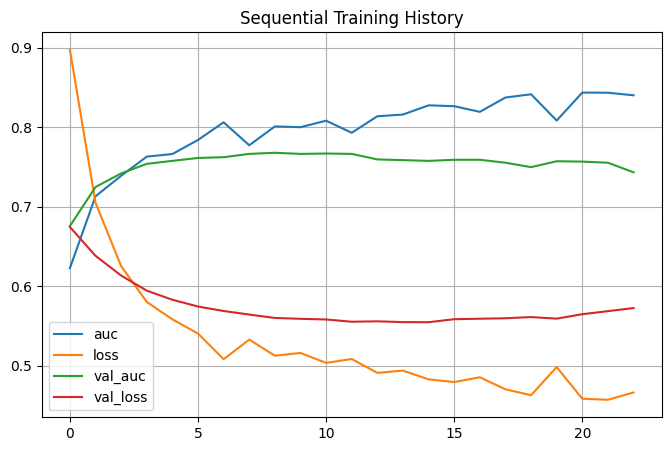

Functional training curves:


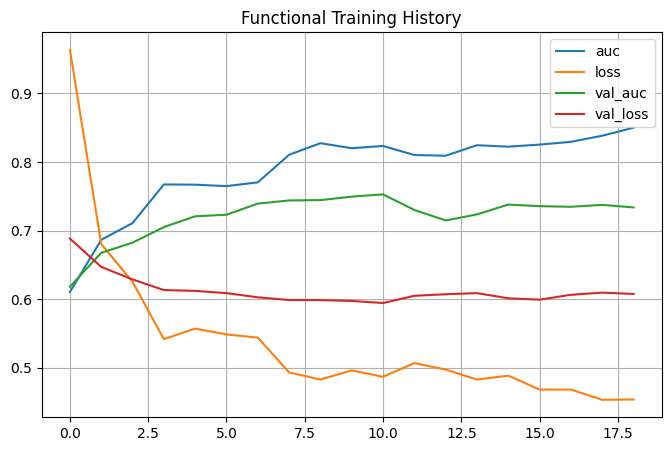

Best classical model (from GridSearch results): LogisticRegression


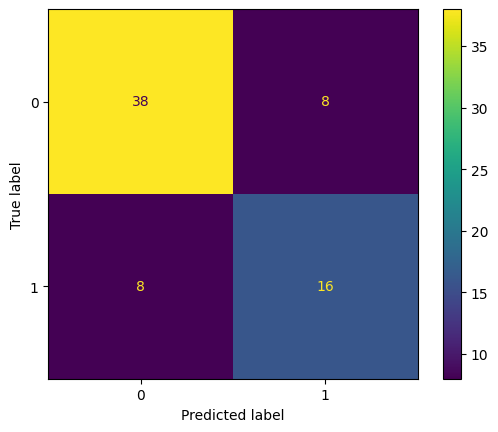

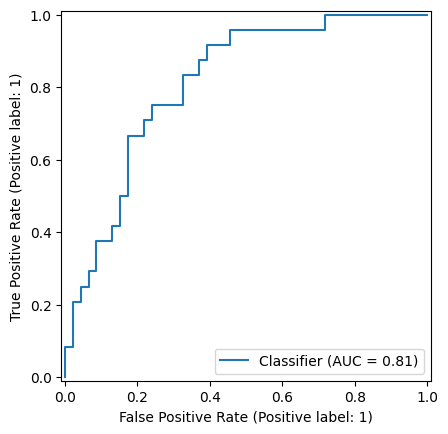

In [68]:
# Plots for DL and classical models
# Plot DL learning curves
def plot_history(hist, title="History"):
    pd.DataFrame(hist).plot(figsize=(8,5))
    plt.title(title)
    plt.grid(True)
    plt.show()

print("Sequential training curves:")
plot_history(history_seq.history, "Sequential Training History")

print("Functional training curves:")
plot_history(history_func.history, "Functional Training History")

# Confusion matrix & ROC for best classical model (based on roc_auc)
best_classical = results_df.iloc[0]['model']
print("Best classical model (from GridSearch results):", best_classical)
# load best estimator again quickly by retraining on full train (or retrieve from GridSearch if stored) - for now display confusion for saved best from earlier run
# Plot confusion matrix and ROC for Sequential
plot_confusion(y_test_tensor, y_pred_seq)
plot_roc_curve(y_test_tensor, y_proba_seq)


## Experiments log & table

Create a reproducible experiments table logging: model, approach (ML/DL), hyperparameters, dataset split, evaluation metrics, and observations.

In [69]:
# Create experiments log (combine classical + DL results)

exp_cols = [
    'id', 'model', 'approach', 'hyperparameters',
    'train_size', 'val_size', 'test_size',
    'accuracy', 'precision', 'recall', 'f1', 'roc_auc',
    'observations'
]

exp_records = []  # we'll collect rows here

# --- Add classical ML results ---
for i, row in results_df.reset_index(drop=True).iterrows():
    exp_records.append({
        'id': f"C{i+1}",
        'model': row['model'],
        'approach': 'Classical',
        'hyperparameters': str(row.get('best_params', 'N/A')),
        'train_size': X_train.shape[0],
        'val_size': X_val.shape[0],
        'test_size': X_test.shape[0],
        'accuracy': row.get('accuracy', None),
        'precision': row.get('precision', None),
        'recall': row.get('recall', None),
        'f1': row.get('f1', None),
        'roc_auc': row.get('roc_auc', None),
        'observations': ''
    })

# --- Add Deep Learning results ---
exp_records.extend([
    {
        'id': 'DL1',
        'model': 'Sequential_DNN',
        'approach': 'DeepLearning',
        'hyperparameters': "{layers:[64,32], dropout:0.3, batch_size:32, epochs:...}",
        'train_size': X_train.shape[0],
        'val_size': X_val.shape[0],
        'test_size': X_test.shape[0],
        'accuracy': metrics_seq['accuracy'],
        'precision': metrics_seq['precision'],
        'recall': metrics_seq['recall'],
        'f1': metrics_seq['f1'],
        'roc_auc': metrics_seq['roc_auc'],
        'observations': ''
    },
    {
        'id': 'DL2',
        'model': 'Functional_DNN',
        'approach': 'DeepLearning',
        'hyperparameters': "{layers:[128,64], dropout:0.4, batch_size:32, epochs:...}",
        'train_size': X_train.shape[0],
        'val_size': X_val.shape[0],
        'test_size': X_test.shape[0],
        'accuracy': metrics_func['accuracy'],
        'precision': metrics_func['precision'],
        'recall': metrics_func['recall'],
        'f1': metrics_func['f1'],
        'roc_auc': metrics_func['roc_auc'],
        'observations': ''
    }
])

# --- Convert to DataFrame ---
exp_df = pd.DataFrame(exp_records, columns=exp_cols)

# --- Save to CSV and display ---
exp_df.to_csv("experiments_log_full.csv", index=False)
display(exp_df)
print(" Saved experiments_log_full.csv successfully!")


,id,model,approach,hyperparameters,train_size,val_size,test_size,accuracy,precision,recall,f1,roc_auc,observations
0,C1,LogisticRegression,Classical,{'C': 0.1},323,69,70,0.700000,0.560000,0.583333,0.571429,0.784420,
1,C2,RandomForest,Classical,"{'max_depth': 5, 'n_estimators': 100}",323,69,70,0.728571,0.619048,0.541667,0.577778,0.769022,
2,C3,SVC,Classical,"{'C': 0.1, 'kernel': 'rbf'}",323,69,70,0.657143,0.000000,0.000000,0.000000,0.717391,
3,C4,XGBoost,Classical,"{'learning_rate': 0.1, 'n_estimators': 50}",323,69,70,0.614286,0.440000,0.458333,0.448980,0.689312,
4,DL1,Sequential_DNN,DeepLearning,"{layers:[64,32], dropout:0.3, batch_size:32, e...",323,69,70,0.771429,0.666667,0.666667,0.666667,0.811594,
5,DL2,Functional_DNN,DeepLearning,"{layers:[128,64], dropout:0.4, batch_size:32, ...",323,69,70,0.685714,0.550000,0.458333,0.500000,0.741848,


 Saved experiments_log_full.csv successfully!


## 7) Save models & preprocessor

In [70]:
#Save models and preprocessor artifacts
import joblib

# Save preprocessor
joblib.dump(preprocessor, "preprocessor.joblib")
print("Saved preprocessor.joblib")

# Save classical top model by name (retrain best on train+val if you want full-use model)
best_classical_name = results_df.iloc[0]['model']
print("Top classical model:", best_classical_name)
# For simplicity save the best GridSearch estimator from earlier if available in memory (gs var will be last run)
try:
    joblib.dump(gs.best_estimator_, f"{best_classical_name}_best_estimator.joblib")
    print("Saved classical model:", best_classical_name, "_best_estimator.joblib")
except Exception as e:
    print("Could not save classical model from memory:", e)

# Save DL models
seq.save("sequential_model.keras")
func.save("functional_model.keras")
print("Saved DNNs to sequential_model.keras and functional_model.keras")


Saved preprocessor.joblib
Top classical model: LogisticRegression
Saved classical model: LogisticRegression _best_estimator.joblib
Saved DNNs to sequential_model.keras and functional_model.keras
